# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [2]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, eq_coords_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397", return_eq_coords=True)
_, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

_, eq_coords_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397", return_eq_coords=True)
t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, integrated_beam_rising = stacked_beam_map(theta_c_rising, 
                                                            phi_c_rising, 
                                                            FWHM=1.1, 
                                                            NSIDE=nside, 
                                                            threshold = 0.0111)

In [4]:
full_bool_map, pixel_indices = reduce_bool_maps_LOR([bool_map_setting, bool_map_rising])
integrated_beam = integrated_beam_setting + integrated_beam_rising

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)
Tsky_operator_rising = generate_Tsky_proj(full_bool_map, theta_c_rising, phi_c_rising, FWHM=1.1)

In [6]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

In [7]:
pixel_indices_setting = np.where(bool_map_setting)[0]
sky_params_setting = sky_vector(pixel_indices_setting, 408, Nside=nside, sky_model=None)
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices_setting], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params_setting[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_indices = top_20_beam_indices[top_n_sky_indices]
pixel_indices_setting_1 = pixel_indices_setting[calibration_indices]
print(pixel_indices_setting_1)

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices_setting], -200)[-200:]
calibration_5_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]
pixel_indices_setting_5 = pixel_indices_setting[calibration_5_indices]


[21996]


In [8]:


sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

# For a 1D array 'integrated_beam_setting'
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam[pixel_indices], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_db_indices = top_20_beam_indices[top_n_sky_indices]
pixel_indices_db_1 = pixel_indices[calibration_db_indices]

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam[pixel_indices], -200)[-200:]
calibration_db_5indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]
pixel_indices_db_5 = pixel_indices[calibration_db_5indices]

Number of pixels:  473


In [16]:
hp.pix2ang(nside, pixel_indices_setting_5)

(array([1.58121318, 1.57079633, 1.52911759, 1.45596077, 1.47690845]),
 array([2.55254403, 2.71207803, 2.66299065, 2.92069942, 2.92069942]))

In [9]:
# Obtain (RA, DEC) coordinates for the pixels:
# For pixel_indices_setting_1:
theta_s_1, phi_s_1 = hp.pix2ang(nside, pixel_indices_setting_1)
ra_s_1 = np.degrees(phi_s_1)
dec_s_1 = 90.0 - np.degrees(theta_s_1) 

theta_s_5, phi_s_5 = hp.pix2ang(nside, pixel_indices_setting_5)
ra_s_5 = np.degrees(phi_s_5)
dec_s_5 = 90.0 - np.degrees(theta_s_5) 

theta_db_1, phi_db_1 = hp.pix2ang(nside, pixel_indices_db_1)
ra_db_1 = np.degrees(phi_db_1)
dec_db_1 = 90.0 - np.degrees(theta_db_1)

theta_db_5, phi_db_5 = hp.pix2ang(nside, pixel_indices_db_5)
ra_db_5 = np.degrees(phi_db_5)
dec_db_5 = 90.0 - np.degrees(theta_db_5)

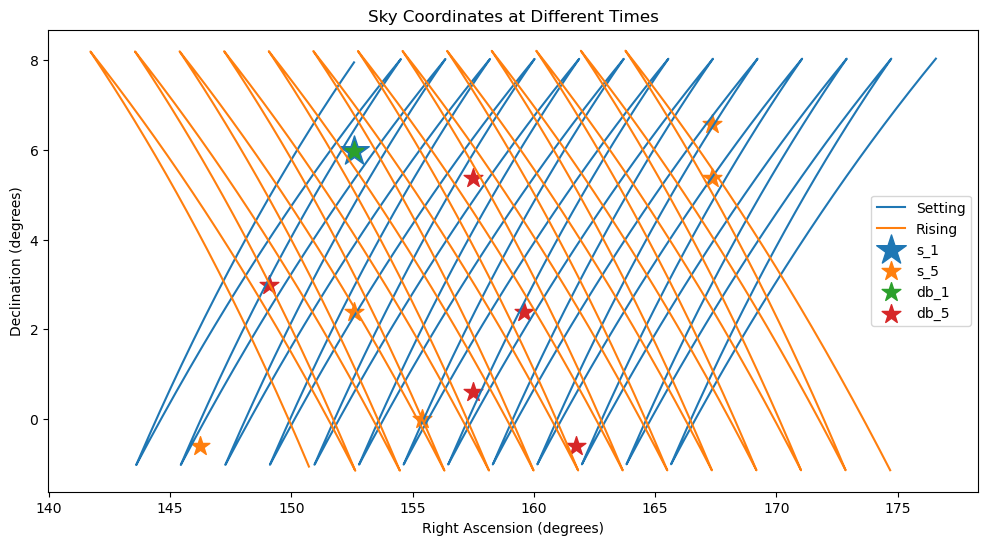

In [ ]:

# ---- Plot results ----
# Generate a 2D plot of (RA, Dec) coordinates
plt.figure(figsize=(12, 6))
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, label='Setting')
plt.plot(eq_coords_rising.ra, eq_coords_rising.dec, label='Rising')
plt.scatter(ra_s_1, dec_s_1, label='s_1', marker='*', s=300, color='red')
plt.scatter(ra_s_5, dec_s_5, label='s_5', marker='*', s=300, color='green')
plt.scatter(ra_db_5, dec_db_5, label='db_5', marker='*', s=300, color='blue')
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("Sky Coordinates at Different Times")
plt.legend()
plt.show()

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_85982/967783807.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_85982/967783807.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_db_5, dec_db_5,


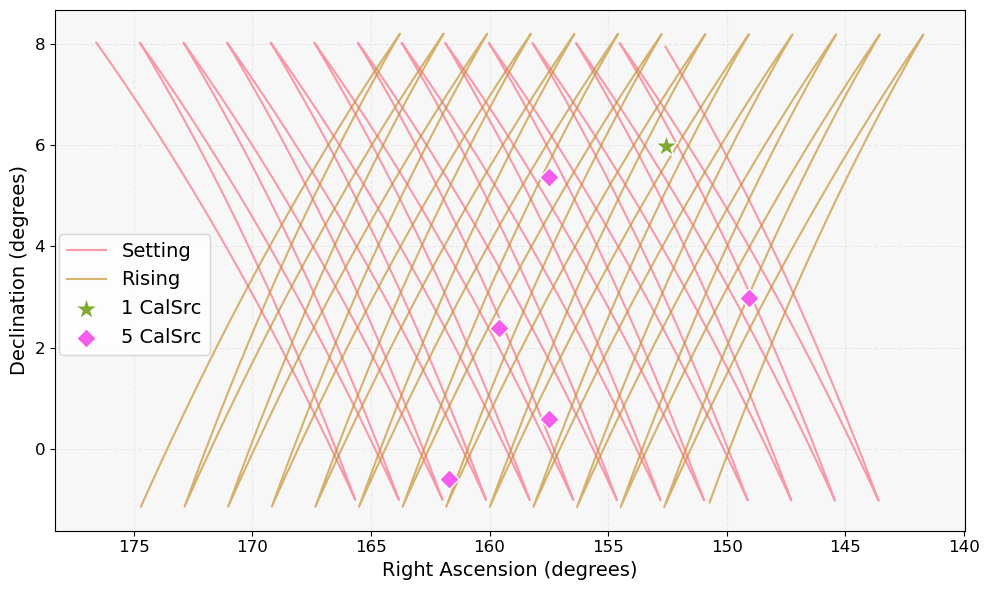

In [70]:
import seaborn as sns


# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')
plt.plot(eq_coords_rising.ra, eq_coords_rising.dec, 
         color=colors[1],
         alpha=0.7,
         linewidth=1.5,
         label='Rising')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
# plt.scatter(ra_s_5, dec_s_5,
#             marker='s',
#             c=colors[4],
#             s=100,
#             **marker_params,
#             label='5 CalSrc')
plt.scatter(ra_db_5, dec_db_5,
            marker='D',
            c=colors[6],
            s=100,
            **marker_params,
            label='5 CalSrc')

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=14)
plt.ylabel("Declination (degrees)", fontsize=14)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
plt.gca().set_facecolor('#f7f7f7')
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.17, 0.57),
           borderaxespad=0,
           frameon=True,
           # title=' '
           fontsize=14
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("observation_pattern_2.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_85982/1707524116.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_85982/1707524116.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_5, dec_s_5,


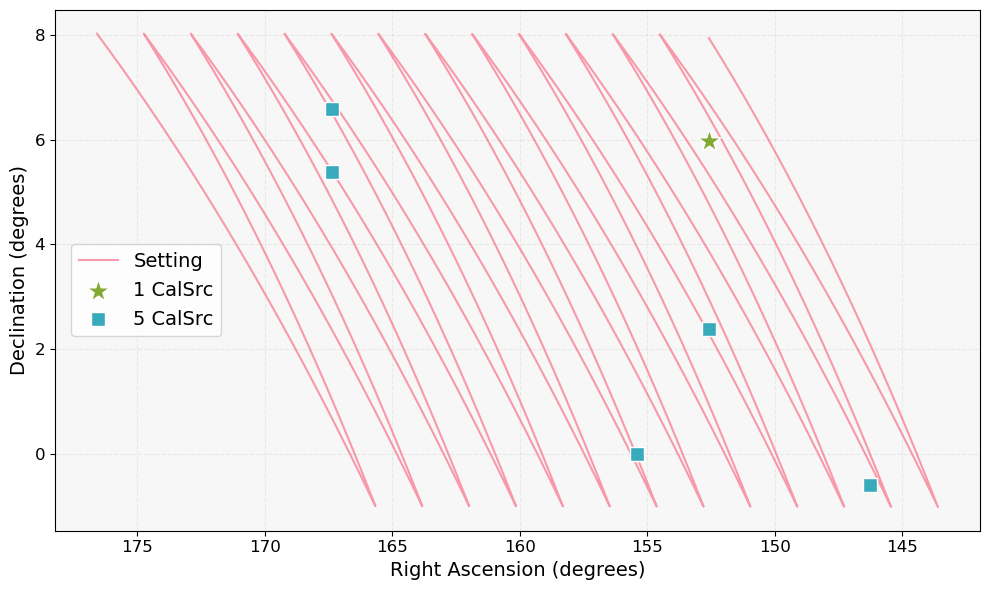

In [64]:
# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
plt.scatter(ra_s_5, dec_s_5,
            marker='s',
            c=colors[4],
            s=100,
            **marker_params,
            label='5 CalSrc')

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=14)
plt.ylabel("Declination (degrees)", fontsize=14)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
plt.gca().set_facecolor('#f7f7f7')
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.18, 0.55),
           borderaxespad=0,
           frameon=True,
           # title=' '
           fontsize=14
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("observation_pattern_1.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

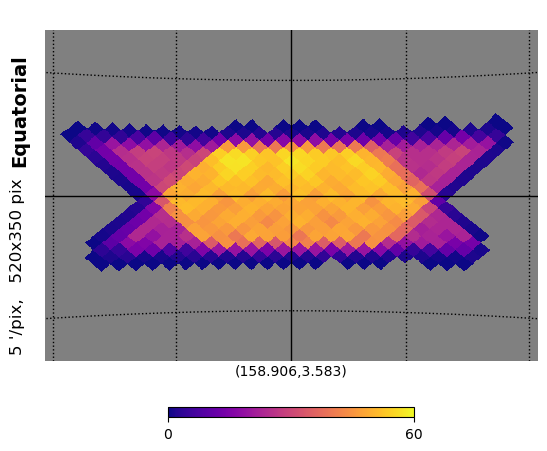

In [57]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

patch_integrated_beam = view_patch_map(integrated_beam, pixel_indices)

hp.gnomview(patch_integrated_beam, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           #unit="K", 
           cmap='plasma',
           min=0, max=60,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('integrated_beam_2.pdf', bbox_inches='tight', 
            pad_inches=0.1)

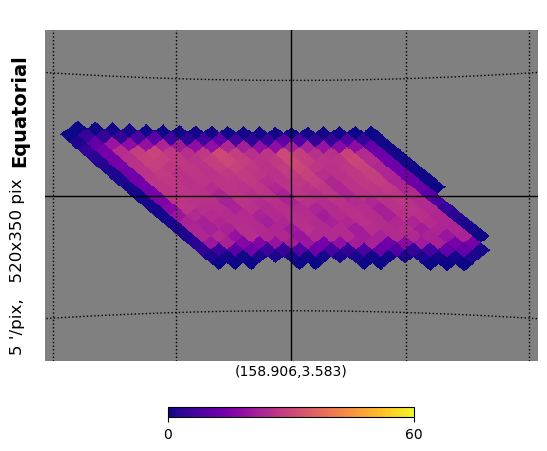

In [ ]:
# Get pixel coordinates
from notebooks.sim_single_TOD_results import norm


theta, phi = hp.pix2ang(nside, pixel_indices_setting)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

patch_integrated_beam = view_patch_map(integrated_beam_setting, pixel_indices_setting)

hp.gnomview(patch_integrated_beam, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           #unit="K", 
           cmap='plasma',
           min=0, max=60,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style

plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('integrated_beam_1.pdf', bbox_inches='tight', 
            pad_inches=0.1)

### 2. Define Tdiode and Trec

### 3. Define Gain and Noise

In [ ]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])
gains_setting = gain_proj @ gain_params_setting


gain_params_rising = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gains_rising  = gain_proj @ gain_params_rising 

# save the gain parameters
# np.savez('outputs/sim1/gain_params.npz', gain_params_setting=gain_params_setting, gain_params_rising=gain_params_rising)

In [ ]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)
noise_rising = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [ ]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

Tsys_rising = Tsky_operator_rising @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_rising = Tsys_rising * (1+noise_rising) * gains_rising

## B. Sampling

In [ ]:
def reduce_bool_maps_LAND(bool_maps):
    """
    Reduce a list of boolean maps using the "logical and" operation.
    """
    reduced_map = np.logical_and.reduce(bool_maps)
    # Get the pixel indices of the "1" pixels:
    pixel_indices = np.where(reduced_map)[0]
    return reduced_map, pixel_indices

In [ ]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

# Convert theta/phi coordinates to HEALPix pixels
# pixels_c_rising = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
#           for theta, phi in zip(theta_c_rising, phi_c_rising)]
# bool_map_c_rising = np.zeros(hp.nside2npix(nside))
# bool_map_c_rising[pixels_c_rising] = 1

# LAND_bool_map, shared_pixel_indices = reduce_bool_maps_LAND([bool_map_c_setting, bool_map_c_rising])
# shared_indices = [list(pixel_indices).index(item) for item in shared_pixel_indices]

# # For a 1D array 'integrated_beam_setting'
# n_cal_pixs=1
# top_20_beam_indices = np.argpartition(integrated_beam[pixel_indices], -20)[-20:]
# top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
# calibration_indices = top_20_beam_indices[top_n_sky_indices]

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam[pixel_indices], -200)[-200:]
calibration_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]

#### Visualize the Tsky samples

In [ ]:
sky_min = np.min(sky_params)
sky_max = np.max(sky_params)

In [ ]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=10, max=35,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim1/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-2.8, max=2.8,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim1/error_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)



hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim1/std_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:

# # ---- Plot results ----
# # Generate a 2D plot of (RA, Dec) coordinates
# plt.figure(figsize=(12, 6))
# plt.scatter(equatorial_coords_setting.ra, equatorial_coords_setting.dec)
# plt.scatter(equatorial_coords_rising.ra, equatorial_coords_rising.dec)
# plt.xlabel("Right Ascension (degrees)")
# plt.ylabel("Declination (degrees)")
# plt.title("Sky Coordinates at Different Times")
# plt.show()


### Other components

In [ ]:
gain_samples = np.load("outputs/sim1/gain_samples.npy")

In [ ]:
gain_samples.shape

In [ ]:
view_samples()

gain_samples = np.load("outputs/sim1/gain_samples.npy")